In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [11]:
#use inspect to find columns within each table
inspector = inspect(engine)

In [12]:
#get columns for mesurement table
columns=inspector.get_columns('measurement')

for column in columns:
    print (column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#get columns for station table
columns=inspector.get_columns('station')

for column in columns:
    print (column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

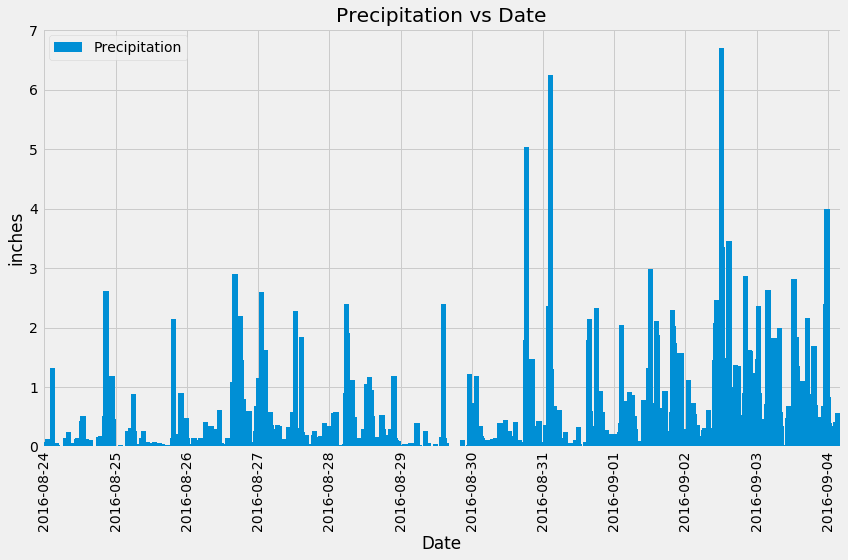

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

result=session.query(Measurement).order_by(Measurement.date.desc()).first()
last_date=result.date
#print(last_date)

year_ago=(dt.datetime.strptime(last_date, '%Y-%m-%d') - relativedelta(years=1)).date()
#print(year_ago)

# Perform a query to retrieve the data and precipitation scores

data=session.query(Measurement.date,Measurement.prcp)\
.filter(Measurement.date>=year_ago)\
.filter(Measurement.date<=last_date).all()

#print(data)

# Save the query results as a Pandas DataFrame and set the index to the date column

#Create DataFrame based on result from query
precip_df=pd.DataFrame(data)

#Rename columns
precip_df.columns=["Date","Precipitation"]


precip_df.set_index("Date",inplace=True)


# Sort the dataframe by date

precip_df.sort_index()
precip_df.head()

# Use Pandas Plotting with Matplotlib to plot the data

precip_fig=precip_df.plot.bar(figsize=(12,8),width=15, rot=90,title='Precipitation vs Date',grid=True)

precip_fig.xaxis.set_major_locator(plt.MaxNLocator(12))

precip_fig.set_ylabel("inches")

#precip_fig.set_xticks(range(1,10),precip_fig["Date"], rotation=90)

#plt.grid()

plt.tight_layout()

_=plt.savefig("Images/Precipitation vs date Plot.png")

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?

station_unique_count=session.query(Measurement.station).distinct().count()

print(f"Unique number stations in the dataset is: {station_unique_count}")

Unique number stations in the dataset is: 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

for row in station_count:
    print(f"Station Name: {row[0]}, Count: {row[1]}")

Station Name: USC00519281, Count: 2772
Station Name: USC00519397, Count: 2724
Station Name: USC00513117, Count: 2709
Station Name: USC00519523, Count: 2669
Station Name: USC00516128, Count: 2612
Station Name: USC00514830, Count: 2202
Station Name: USC00511918, Count: 1979
Station Name: USC00517948, Count: 1372
Station Name: USC00518838, Count: 511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.count(Measurement.tobs))\
.filter(Measurement.station=='USC00519281').all()

[('USC00519281', 54.0, 85.0, 2772)]

2017-08-18


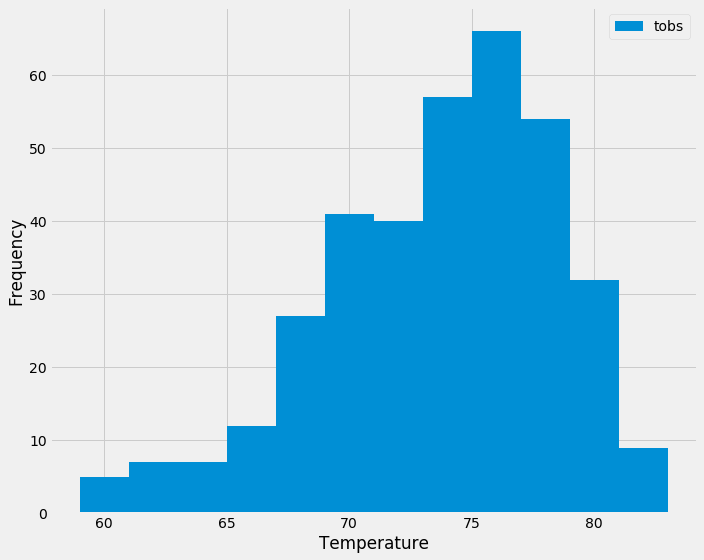

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Calculate the last date for which measurement is available for the station
result=session.query(Measurement).filter(Measurement.station=='USC00519281').order_by(Measurement.date.desc()).first()
last_date=result.date
print(last_date)

# Calculate 1 year old date from date found in above query

year_ago=(dt.datetime.strptime(last_date, '%Y-%m-%d') - relativedelta(years=1)).date()

# find data for last 12 months

data_active_station=session.query(Measurement.date,Measurement.tobs)\
.filter(Measurement.date>=year_ago)\
.filter(Measurement.date<=last_date)\
.filter(Measurement.station=='USC00519281').all()

#Assign the data into dataframe for plotting

temp_active_station=pd.DataFrame(data_active_station)
temp_active_station.head()

#Plotting the histogram for the same
temp_active_station_hist=temp_active_station.plot.hist(temp_active_station["tobs"],figsize=(10,8),bins=12)

temp_active_station_hist.set_xlabel("Temperature")

plt.tight_layout()

_=plt.savefig("Images\station-hist.png")

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-01-01', '2017-01-07'))

[(62.0, 68.36585365853658, 74.0)]


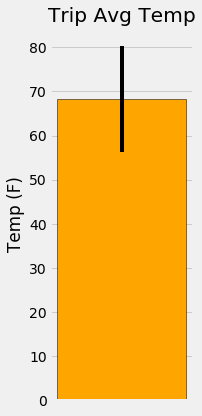

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_trip_last_year=calc_temps('2017-01-01', '2017-01-07')
for data in temp_trip_last_year:
    temp_min=data[0]
    temp_ave=data[1]
    temp_max=data[2]
    peak_to_peak=temp_max-temp_min
#print(temp_max,temp_ave,temp_max,peak_to_peak)

plt.figure(figsize=(3,6))

plt.bar('2017-01-01',temp_ave,
        width=1,
        color='orange',
        edgecolor='k',
        yerr = peak_to_peak)
plt.xticks([])

plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

plt.tight_layout()

#plt.show()

_=plt.savefig("Images\Temperature Error Bar.png")

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]
session.query(*sel).filter(Measurement.station == Station.station)\
.filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2017-01-01")\
.filter(func.strftime("%Y-%m-%d", Measurement.date) <= "2017-01-07")\
.group_by(Station.name, Station.latitude, Station.longitude, Station.elevation)\
.order_by(func.sum(Measurement.prcp).desc())\
.all()



[(0.61, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (0.6, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (0.6, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (0.35, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (0.2, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (0.0, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

from datetime import timedelta, date
date_range_list=[]

# Set the start and end date of the trip

start_dt = date(2017, 1, 1)
end_dt = date(2017, 1, 7)

# Use the start and end date to create a range of dates

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
# Stip off the year and save a list of %m-%d strings
for dt in daterange(start_dt, end_dt):
    
    date_range_list.append((dt.strftime("%m-%d")))

#print(date_range_list)

# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normal={}
daily_normal["date"]=[]
daily_normal["t_min"]=[]
daily_normal["t_avg"]=[]
daily_normal["t_max"]=[]

for date in date_range_list:
    daily_normal["date"].append("2018-"+date)
    #print(daily_normals(date))
    for x in daily_normals(date):
        daily_normal["t_min"].append(x[0])
        daily_normal["t_avg"].append(x[1])
        daily_normal["t_max"].append(x[2])

        
print(daily_normal)

{'date': ['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07'], 't_min': [62.0, 60.0, 62.0, 58.0, 56.0, 61.0, 57.0], 't_avg': [69.15384615384616, 69.39622641509433, 68.9090909090909, 70.0, 67.96428571428571, 68.96491228070175, 68.54385964912281], 't_max': [77.0, 77.0, 77.0, 76.0, 76.0, 76.0, 76.0]}


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_daily_normal_df=pd.DataFrame(daily_normal)
trip_daily_normal_df.set_index("date",inplace=True)

trip_daily_normal_df


,t_min,t_avg,t_max
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


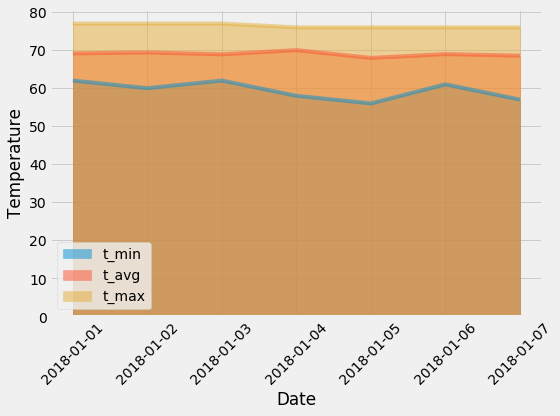

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
trip_daily_normal_plot=trip_daily_normal_df.plot(kind='area',stacked=False,rot=45,figsize=(8,6),grid=True)

trip_daily_normal_plot.set_xlabel("Date")
trip_daily_normal_plot.set_ylabel("Temperature")
plt.tight_layout()


_=plt.savefig("Images\DailyTemperature.png")